# Final Assigment for ASTR-19

In [1]:
import numpy as np
import sep

In [2]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits 
import astropy
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
# read image into standard 2-d numpy array
hdul = fits.open('jw02731-o001_t017_nircam_clear-f090w_i2d.fits') #convert fits to a np array

#with fits.open('jw02731-o001_t017_nircam_clear-f090w_i2d.fits') as hdul:
 #  hdul.verify('fix')
  # data = hdul[1].data

file_reference = 'jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
with fits.open(file_reference) as hdulist:
  
    data = hdulist[1].data

#hdul.info()

#hdul.close()
#print(data)

First, we’ll read an example image from a FITS file and display it, just to show what we’re dealing with. The example image is just 256 x 256 pixels.

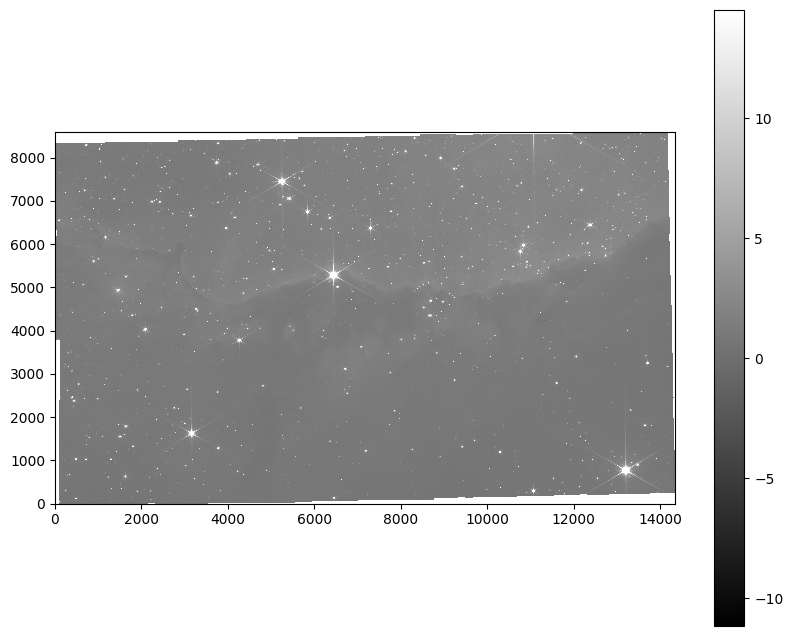

In [4]:
# show the image
m = np.nanmean(data)
s = np.nanstd(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=(m+s), origin='lower')
plt.colorbar();
plt.show()

# Background subtraction
Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [5]:
# measure a spatially varying background on the image
data = data.astype(data.dtype.newbyteorder('='))
#nonandata=np.nan_to_num(data, copy=True, nan=0.0, posinf=None, neginf=None)
#bkg = sep.Background(data)


There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:



In [6]:
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. We can now do various things with this Background object:

In [7]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

1.1956995725631714
0.06582547724246979


In [8]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
#bkg_image = np.array(bkg) # equivalent to above

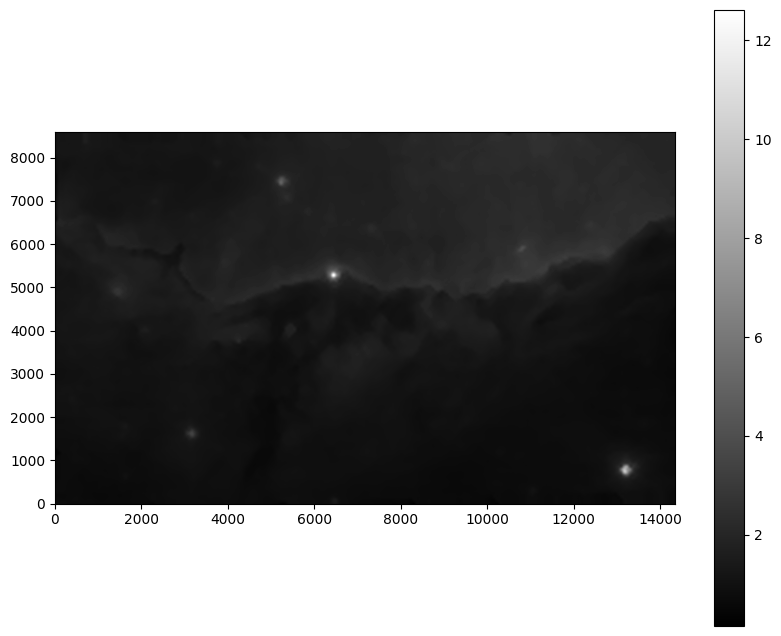

In [9]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('test3.png')

In [10]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

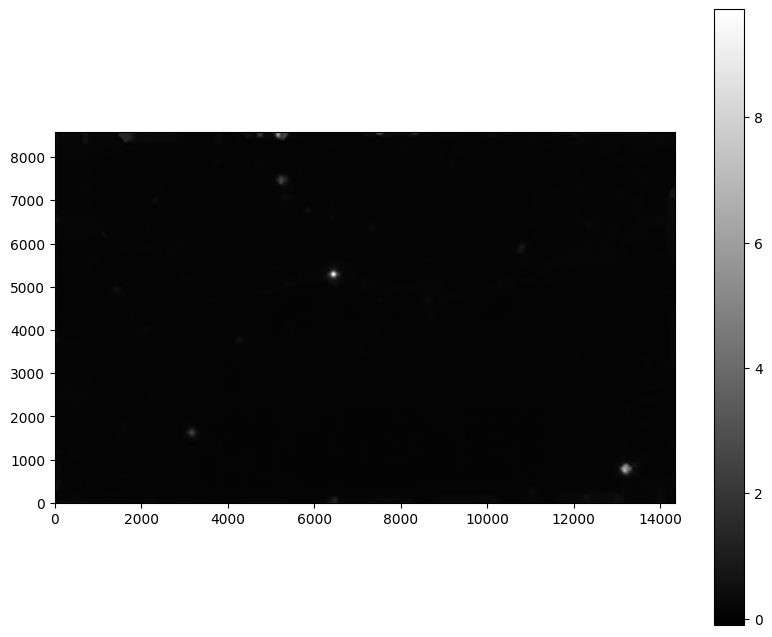

In [11]:
# show the background noise
# I didnt know what to set the mask value to here so I just left it empty
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [12]:
# subtract the background
data_sub = data - bkg

# Object detection
Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5(sigma) where sigma is the global background RMS.

In [13]:
def rescale_image(data,vmin=0.5,vmax=100):
    # copy the data to avoid accidentaly overwriting it
    data_tmp = data.copy()

    # compute the mean value over all data, excluding NaN (Not a Number)
    m = np.nanmean(data_tmp)

    # any data points below vpmin is assigned the value vpmin
    # any data points above vpmax is assigned the value vpmax
    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    # replace all NaN by vpmin
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    # apply log-scale
    data_tmp = np.log10(data_tmp)
    return data_tmp
    
data_sub_res = rescale_image(data_sub)

In [14]:
objects = sep.extract(data_sub_res, 1.5, err=bkg.globalrms)

In [15]:
# how many objects were detected
len(objects)

8103

## lets look at our image and data

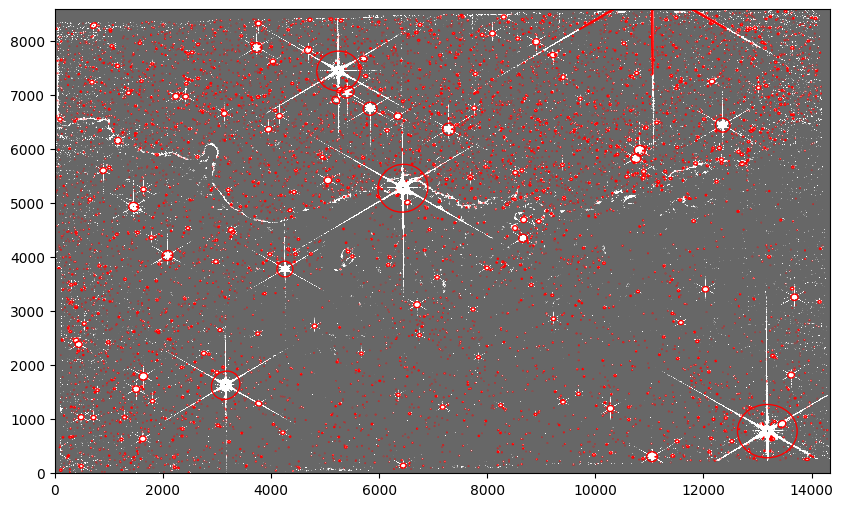

In [16]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub_res), np.std(data_sub_res)
im = ax.imshow(data_sub_res, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('test4.png')


--- Analyzing Object Fluxes ---
Number of detected sources: 8103


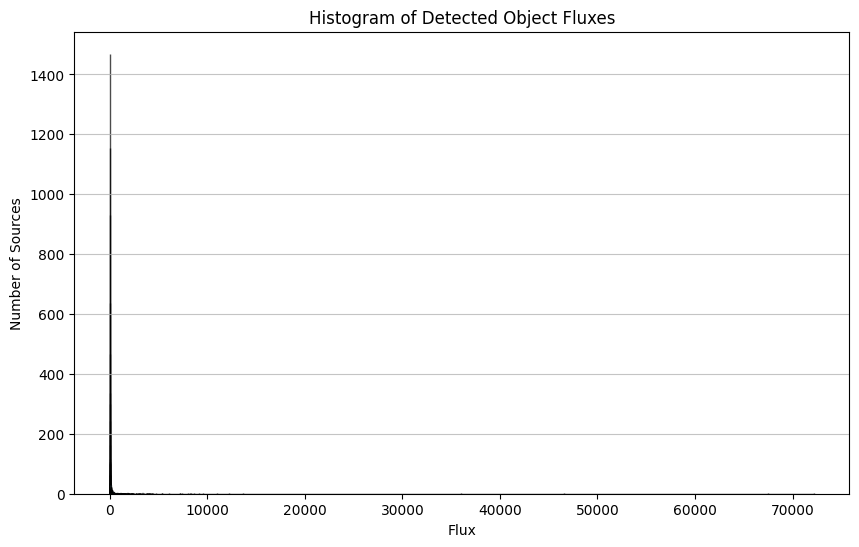

Mean flux: 124.94
Median flux: 12.93
Standard deviation of fluxes: 1364.74

Largest outlier flux: 72212.66
Location of largest outlier (x, y): (13181.70, 779.27)
Largest outlier is 52.82 standard deviations away from the mean.


In [17]:
print("\n--- Analyzing Object Fluxes ---")
fluxes = objects['flux']

# get sources
num_sources = len(fluxes)
print(f"Number of detected sources: {num_sources}")

# histogram of fluxes.
plt.figure(figsize=(10, 6)) # Create a new figure 
plt.hist(fluxes, bins='auto', alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel('Flux')
plt.ylabel('Number of Sources')
plt.title('Histogram of Detected Object Fluxes')
plt.grid(axis='y', alpha=0.75)
plt.show()

# what are the mean median and standard deviation of fluxes?
mean_flux = np.mean(fluxes)
median_flux = np.median(fluxes)
std_flux = np.std(fluxes)
print(f"Mean flux: {mean_flux:.2f}")
print(f"Median flux: {median_flux:.2f}")
print(f"Standard deviation of fluxes: {std_flux:.2f}")

# what is the largest outlier? 
max_flux_index = np.argmax(fluxes)
largest_outlier_flux = fluxes[max_flux_index]
outlier_x = objects['x'][max_flux_index]
outlier_y = objects['y'][max_flux_index]

# calculate std away from the mean
std_devs_away = (largest_outlier_flux - mean_flux) / std_flux

print(f"\nLargest outlier flux: {largest_outlier_flux:.2f}")
print(f"Location of largest outlier (x, y): ({outlier_x:.2f}, {outlier_y:.2f})")
print(f"Largest outlier is {std_devs_away:.2f} standard deviations away from the mean.")




### This is the reproject script used to reproject the FITS files

In [ ]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference ='jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = 'jw02731-o001_t017_nircam_clear-f200w_i2d.fits'
fname2 = 'jw02731-o001_t017_nircam_clear-f187n_i2d.fits'
fname3 = 'jw02731-o001_t017_nircam_clear-f335m_i2d.fits'
fname4 = 'jw02731-o001_t017_nircam_clear-f444w_i2d.fits'
fname5 = 'jw02731-o001_t017_nircam_f444w-f470n_i2d.fits'

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")


# Lets make our final image

In [18]:
# define file names
fdata_F090W = "jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
fdata_F200W = "jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits"
fdata_F187N = "jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits"
fdata_F335M = "jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits"
fdata_F444W = "jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits"
fdata_F470N = "jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits"

# open the fits files
hdu_1 = fits.open(fdata_F090W)
hdu_2 = fits.open(fdata_F200W)
hdu_3 = fits.open(fdata_F187N)
hdu_4 = fits.open(fdata_F335M)
hdu_5 = fits.open(fdata_F444W)
hdu_6 = fits.open(fdata_F470N)

# show information about fits files
hdu_1.info()
hdu_2.info()
hdu_3.info()
hdu_4.info()
hdu_5.info()
hdu_6.info()

Filename: jw02731-o001_t017_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        75   (14339, 8582)   float32   
  2  ERR           1 ImageHDU        10   (14339, 8582)   float32   
  3  CON           1 ImageHDU        10   (14339, 8582, 6)   int32   
  4  WHT           1 ImageHDU         9   (14339, 8582)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (14339, 8582)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (14339, 8582)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (14339, 8582)   float32   
  8  HDRTAB        1 BinTableHDU    532   160R x 261C   [23A, 5A, 3A, 45A, 6A, 13A, 7A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 32A, 21A, 3A, 3A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 23A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 8A, 8A, 5A, D, D, D, D, D, D, 27A, D, D, 6A, 5A, 1A, 5A, 5A, 5A, L, 4A, K, 5A, 9A, D, D, D

In [19]:
data_1 = hdu_1[1].data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data
data_5 = hdu_5[0].data
data_6 = hdu_6[0].data

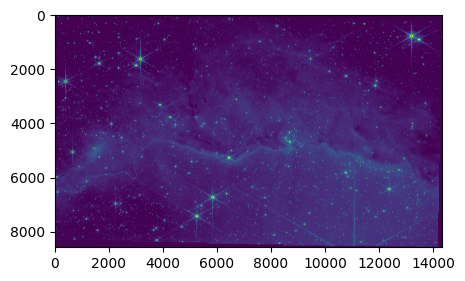

In [20]:
#lets look at one of our data points and rescaled
f = plt.figure(figsize=(5,5))

data_res = rescale_image(data_2)

plt.imshow(data_res)

In [21]:
### Let's combine the data into a single object, where each layer will correspond to a color
data_all = np.zeros((data_res.shape[0],data_res.shape[1],3))

data_all[:,:,0] = data_4 
data_all[:,:,0] = data_6 
data_all[:,:,1] = data_3 
data_all[:,:,1] = data_1 
data_all[:,:,2] = data_5
data_all[:,:,2] = data_2

# rescale the data so we can see features
# try different values of vmin and vmax!
data_all_res = rescale_image(data_all)

In [22]:
# lets take a look at what we just did

print(np.shape(data_all_res), print(np.shape(data_all_res)))

(8582, 14339, 3)
(8582, 14339, 3) None


#### Make a function to map data to [0,1] rgb values

Right now, data_all_res array contains values of intensity (in arbitrary units), but it needs to be mapped to [0,1] for RGB coloring. Let's define a function a function that does this automatically.

In [23]:
def remap(data):
    #copy the data to avoid accidently overwriting it
    data_tmp = data.copy()

    dmin = data_tmp.min()
    dmax = data_tmp.max()
    return (data_tmp - dmin)/(dmax-dmin)

### Now lets make an RGB image

In [24]:
rgb_image = np.zeros((data_2.shape[0],data_2.shape[1],3))
rgb_image = np.zeros((data_4.shape[0],data_4.shape[1],3))
rgb_image = np.zeros((data_1.shape[0],data_1.shape[1],3))
rgb_image = np.zeros((data_3.shape[0],data_3.shape[1],3))
rgb_image = np.zeros((data_5.shape[0],data_5.shape[1],3))
rgb_image = np.zeros((data_6.shape[0],data_6.shape[1],3))
rgb_image = remap(data_all_res)


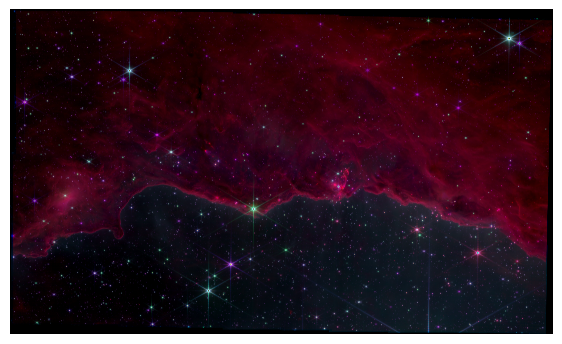

In [25]:
#now lets plottt!
f,ax = plt.subplots(1,1,figsize=(7,7))
ax.axis('off')
# this was my favorite color combination
ax.imshow(rgb_image)

plt.savefig('final_project_jwst_image.png',bbox_inches='tight',pad_inches=0,dpi=1000)

In [26]:
print('Thank you Artem!')

Thank you Artem!
